In [1]:
from functools import partial
from typing import *

import torch
from torch import Tensor
import transformers
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import llminference as L

torch.set_num_threads(32)

sns.set_context("paper", font_scale=1.5)
matplotlib.rc('font', **{'family': 'serif', 'serif': ["CMU Serif"]})
matplotlib.rc('text', usetex=True)
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

'/usr/share/fonts/truetype/cmu/cmunrm.ttf'

In [2]:
adapter = L.Adapter.from_pretrained("EleutherAI/pythia-1.4b")
data = L.qa.SQuAD.data()
examples = [L.qa.add_few_shot_prompt(data[i], k=1, prompt_template=L.qa.get_default_prompt_template(adapter.model.config._name_or_path, shots=1))
    for i in range(100)]

Found cached dataset squad (/nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-03400b5d173ab796.arrow
Loading cached shuffled indices for dataset at /nethome/douglaso/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453/cache-c374d8616db3e9e0.arrow


In [3]:
log_q = {}
log_k = {}
log_m = {}
def logging_attn(layer_idx, self, query, key, value, attention_mask=None, head_mask=None):
    q = torch.nn.functional.pad(query, [0, 0, 2048 - query.shape[2], 0, 0, 0, 0, 0])
    k = torch.nn.functional.pad(key, [0, 0, 2048 - key.shape[2], 0, 0, 0, 0, 0])
    m = torch.nn.functional.pad(attention_mask, [2048 - key.shape[2], 0, 0, 0, 0, 0], value=-1e9)
    log_q[layer_idx] = torch.concat([log_q[layer_idx], q], axis=0) if layer_idx in log_q else q
    log_k[layer_idx] = torch.concat([log_k[layer_idx], k], axis=0) if layer_idx in log_k else k
    log_m[layer_idx] = torch.concat([log_m[layer_idx], m], axis=0) if layer_idx in log_m else m
    return transformers.models.gpt_neox.modeling_gpt_neox.GPTNeoXAttention._attn(
        self, query, key, value, attention_mask=attention_mask, head_mask=head_mask)

for layer_idx, layer in enumerate(adapter.model.gpt_neox.layers):
    layer.attention._attn = partial(logging_attn, layer_idx, layer.attention)
out = list(L.qa.evaluate(adapter, examples[:20], batch_size=1, output_token_limit=1))

Evaluating EleutherAI/pythia-1.4b:   0%|          | 0/20 [00:00<?, ?it/s]

Evaluating EleutherAI/pythia-1.4b: 100%|██████████| 20/20 [04:35<00:00, 13.80s/it]


In [6]:
def attention_weight(q: Tensor, k: Tensor, mask: Tensor) -> Tensor:
    a = (q @ k.transpose(-1, -2)).mul_(q.shape[-1]**-0.5).add_(mask)
    return torch.nn.functional.softmax(a, dim=-1)

Q = torch.stack(list(log_q.values())).swapaxes(0, 1)[..., -1:, :]
K = torch.stack(list(log_k.values())).swapaxes(0, 1)
M = torch.stack(list(log_m.values())).swapaxes(0, 1)
A = attention_weight(Q, K, M).squeeze(-2)
A.shape

torch.Size([20, 24, 16, 2048])

In [84]:
(log_m[0]==0).sum(-1).float().quantile(torch.tensor([0., 1.]))

tensor([1039., 1792.])

# 1. The output of softmax is dominated by a small number of elements

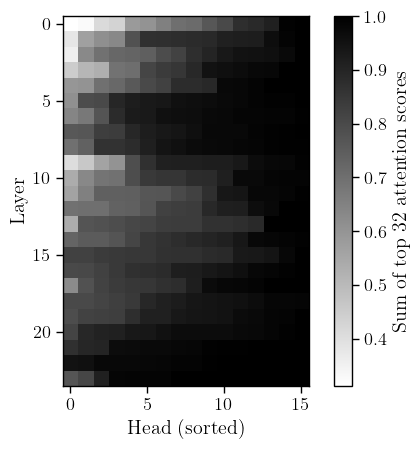

In [90]:
k = 32
topk_metric = torch.topk(A, k=k, dim=-1).values.sum(-1)
ax = plt.gca()
img = ax.imshow(torch.sort(topk_metric.mean(0), dim=1).values, cmap="gray_r", vmax=1)
plt.colorbar(img, ax=ax, label=f"Sum of top {k} attention scores")
ax.set_xlabel("Head (sorted)")
ax.set_ylabel("Layer")
plt.savefig("out/coverage_heatmap.svg", bbox_inches="tight");

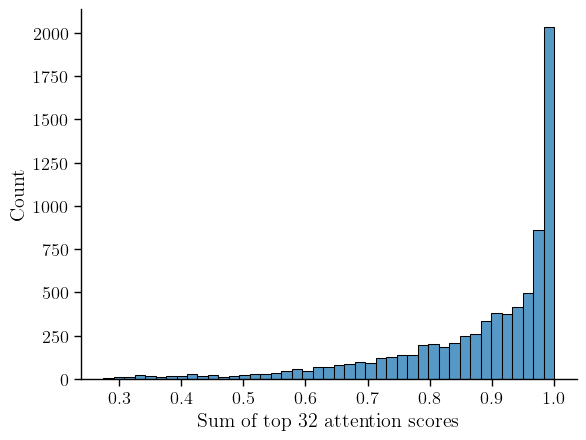

In [91]:
ax = sns.histplot(topk_metric.flatten())
sns.despine(ax=ax)
ax.set_xlabel(f"Sum of top {k} attention scores")
plt.savefig("out/coverage_distribution.svg");

# 2. The indices of the largest attention scores can be predicted without fetching the full $K$ matrix, using the top-magnitude components of $q$

In [70]:
def approx_score(q: Tensor, k: Tensor, mask: Tensor, rank: int, method: str) -> Tensor:
    if method == "top":
        i = torch.topk(q.abs(), k=rank, dim=-1).indices
    elif method == "first":
        i = torch.arange(rank).expand(*q.shape[:-1], rank)
    ik = i.expand(*k[..., :rank].shape)
    return (torch.gather(q, -1, i) @ torch.gather(k, -1, ik).transpose(-1, -2)) + mask

def topk_agreement(a: Tensor, b: Tensor, mask: Tensor, k: int) -> Tensor:
    ma = (a >= -torch.kthvalue(-a, k=k, keepdim=True).values)
    mb = (b >= -torch.kthvalue(-b, k=k, keepdim=True).values)
    m = mask == 0
    return (ma & mb & m).sum(-1) / torch.minimum(m.sum(-1), torch.tensor(k))

rank = 16
k = 32
agreement_top = topk_agreement(A, approx_score(Q[..., -1:, :], K, M, rank=rank, method="top").squeeze(-2), M.squeeze(-2), k=k)
agreement_first = topk_agreement(A, approx_score(Q[..., -1:, :], K, M, rank=rank, method="first").squeeze(-2), M.squeeze(-2), k=k)

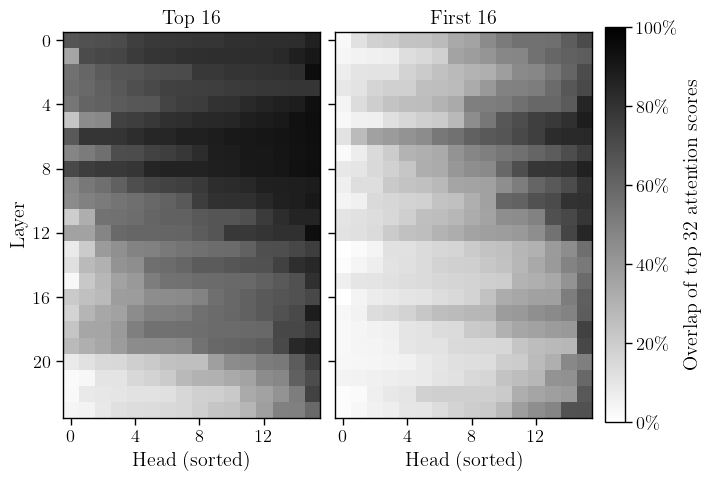

In [92]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(7, 5), sharey=True, layout="constrained")
img = ax0.imshow(torch.sort(agreement_top.mean(0), dim=1).values, cmap="gray_r", vmin=0, vmax=1)
ax1.imshow(torch.sort(agreement_first.mean(0), dim=1).values, cmap="gray_r", vmin=0, vmax=1)
fig.colorbar(img, ax=ax1, shrink=.82, label=f"Overlap of top {k} attention scores", format=lambda x, _: f"{x*100:.0f}\%")
ax0.set_ylabel("Layer")
for ax in [ax0, ax1]:
    ax.set_xlabel("Head (sorted)")
    ax.set_xticks([0, 4, 8, 12])
    ax.set_yticks(list(range(0, 24, 4)))
ax0.set_title(f"Top {rank}")
ax1.set_title(f"First {rank}")
plt.savefig("out/approximation_overlap_heatmap.svg", bbox_inches="tight")

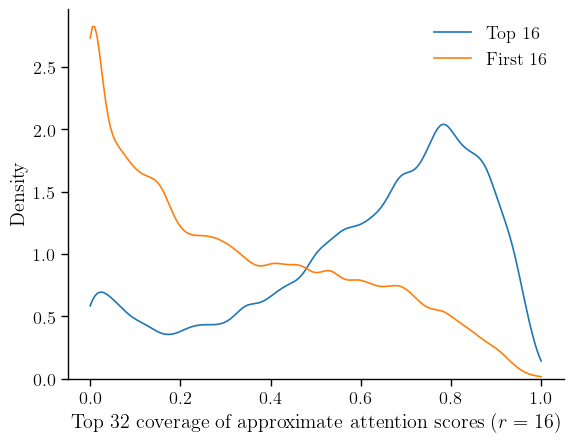

In [93]:
ax = plt.gca()
sns.kdeplot(agreement_top.flatten(), clip=(0, 1), bw_adjust=.5, label=f"Top {rank}", ax=ax)
sns.kdeplot(agreement_first.flatten(), clip=(0, 1), bw_adjust=.5, label=f"First {rank}", ax=ax)
sns.despine(ax=ax)
ax.legend(frameon=False)
ax.set_xlabel(f"Top {k} coverage of approximate attention scores ($r={rank})$")
plt.savefig("out/approximation_overlap_distribution.svg");